# Imports

In [77]:
#import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import seaborn as sns
import os
import wfdb
from scipy import signal
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
#from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import neurokit2 as nk
from sklearn.preprocessing import MinMaxScaler
from scipy.signal import butter, lfilter, freqz, iirnotch

import tensorflow as tf
from tensorflow.keras import layers

# pd.set_option('display.max_columns', None)  # Show all columns
# pd.set_option('display.expand_frame_repr', False)  # Disable wrapping
# pd.set_option('display.max_colwidth', None)  # Show full contents of each cell

pd.reset_option('display.max_columns')  # Show all columns
pd.reset_option('display.expand_frame_repr')  # Disable wrapping
pd.reset_option('display.max_colwidth')  # Show full contents of each cell


# Load data


In [78]:
# import os
# import pandas as pd
# import wfdb

# # Load the CSV file
# superclass_df = pd.read_csv('superclass.csv')

# # Initialize empty arrays to store the data
# data = []

# # Specify the root directory
# root_dir = '../ptb-xl/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3/'

# # Loop over all records in the DataFrame
# for idx, row in superclass_df.iterrows():
#     if (idx+1)%100 == 0:
#         print(f"Processing record {idx+1}/{len(superclass_df)}")
#     # Get filename without extension
#     filename = os.path.splitext(row['filename_lr'])[0]

#     # Construct the full path
#     full_path = os.path.join(root_dir, filename)

#     # Load the raw ECG signal data from the .dat file
#     dat, fields = wfdb.rdsamp(full_path)

#     # Load the labels data from the .hea file
#     hea = wfdb.rdheader(full_path)

#     # Add data to the list
#     data.append({
#         'record_name': filename,
#         'superclass': row['diagnostic_superclass'],
#         'signal': dat,
#         'age': row['age'],
#         'sex': row['sex']
#     })

# # Convert the list to a DataFrame
# df = pd.DataFrame(data)

# # Save the DataFrame
# df.to_pickle('df_processed.pkl')

df = pd.read_pickle('df_processed.pkl')
df

SystemError: deallocated bytearray object has exported buffers

MemoryError: 

# Preprocessing

## One Hot

In [ ]:
# Make sure each label is in a separate list
df['superclass'] = df['superclass'].apply(lambda x: [x] if isinstance(x, str) else x)

mlb = MultiLabelBinarizer()
label_encoded = mlb.fit_transform(df['superclass'])
df_encoded = pd.concat([df.drop('superclass', axis=1), pd.DataFrame(label_encoded, columns=mlb.classes_)], axis=1)

df_encoded


,record_name,signal,age,sex,['CD'],['HYP'],['MI'],['NORM'],['STTC']
0,records100/00000/00001_lr,"[[-0.119, -0.055, 0.064, 0.086, -0.091, 0.004,...",56.0,1,0,0,0,1,0
1,records100/00000/00002_lr,"[[0.004, 0.138, 0.134, -0.072, -0.065, 0.136, ...",19.0,0,0,0,0,1,0
2,records100/00000/00003_lr,"[[-0.029, -0.079, -0.049, 0.054, 0.011, -0.064...",37.0,1,0,0,0,1,0
3,records100/00000/00004_lr,"[[-0.054, -0.138, -0.083, 0.096, 0.015, -0.11,...",24.0,0,0,0,0,1,0
4,records100/00000/00005_lr,"[[-0.034, -0.574, -0.54, 0.304, 0.253, -0.556,...",19.0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...
16239,records100/21000/21833_lr,"[[-0.052, -0.034, 0.018, 0.043, -0.034, -0.008...",67.0,1,0,0,0,0,1
16240,records100/21000/21834_lr,"[[-0.05, -0.013, 0.036, 0.031, -0.042, 0.011, ...",300.0,0,0,0,0,1,0
16241,records100/21000/21835_lr,"[[0.038, 0.024, -0.014, -0.03, 0.026, 0.005, 0...",59.0,1,0,0,0,0,1
16242,records100/21000/21836_lr,"[[-0.057, -0.057, 0.0, 0.057, -0.028, -0.028, ...",64.0,1,0,0,0,1,0


## Distribution of diseases SNOMED

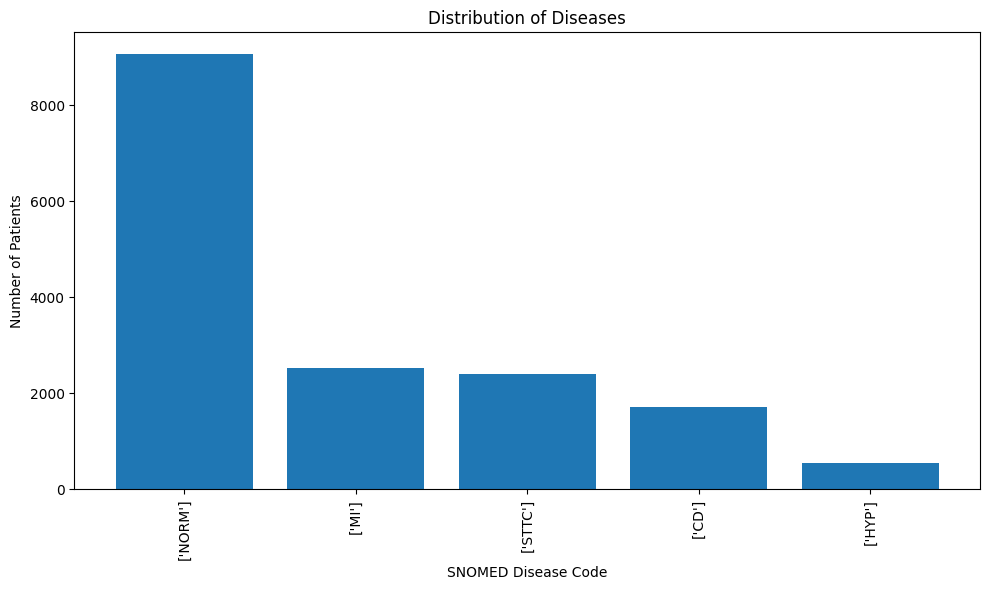

In [ ]:
# Dropping non-disease columns
df_diseases = df_encoded.drop(columns=['record_name', 'signal', 'age', 'sex'])

# Count the number of times each disease is there
disease_counts = (df_diseases == 1).sum()

# Sort the disease counts desc
disease_counts_sorted = disease_counts.sort_values(ascending=False)

disease_counts_sorted

plt.figure(figsize=(10, 6))

# Bar chart
plt.bar(disease_counts_sorted.index.astype(str), disease_counts_sorted.values)
plt.xlabel('SNOMED Disease Code')
plt.ylabel('Number of Patients')
plt.title('Distribution of Diseases')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

## test display

76.92307692307692


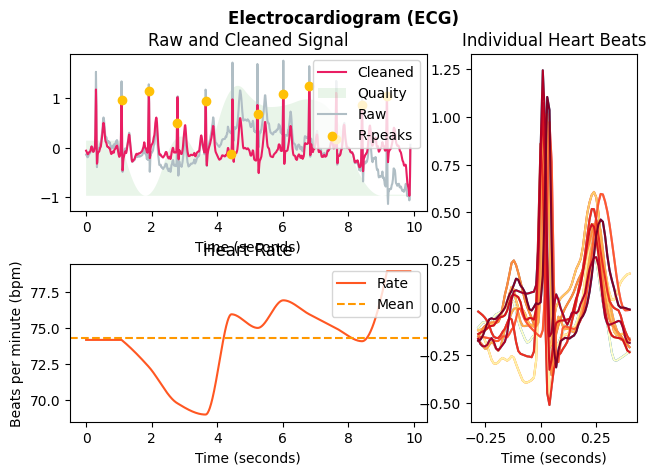

In [ ]:
single_ecg = []
for sublist in df_encoded.loc[3,'signal']: #FIRST PATIENT
    single_ecg.append(sublist[1]) # LEAD II 

#inverted_ecg = nk.ecg_invert(flat_list, sampling_rate=500)
signals, info = nk.ecg_process(single_ecg, sampling_rate=100)
rpeaks = info["ECG_R_Peaks"]
#cleaned_ecg = signals["ECG_Clean"]

# Segment the ECG into individual heartbeats using the R-peaks
heartbeats = np.split(single_ecg, rpeaks)

# TODO check accuracy sans enlever le dernier beat
# Check if the last heartbeat is incomplete (i.e., significantly shorter than the others)
average_heartbeat_length = np.mean([len(heartbeat) for heartbeat in heartbeats])
print(average_heartbeat_length)

if len(heartbeats[-1]) < average_heartbeat_length * 0.75:
    heartbeats = heartbeats[:-1]  # Remove the last heartbeat if incomplete

# Concatenate the heartbeats back into a single ECG signal
cleaned_ecg = np.concatenate(heartbeats)
signals, info = nk.ecg_process(cleaned_ecg, sampling_rate=100)

#plot = nk.events_plot(rpeaks, cleaned_ecg) #WHole ecg

#epochs = nk.ecg_segment(cleaned_ecg, rpeaks=None, sampling_rate=500, show=True) # beatss superimposed

#nk.ecg_plot(signals, sampling_rate=500) # summary of ecg
nk.ecg_plot(signals, sampling_rate=100) # summary of ecg
# _, waves_peak = nk.ecg_delineate(signals, # PQRS peaks
#                                  rpeaks, 
#                                  sampling_rate=500, 
#                                  method="peak", 
#                                  show=True, 
#                                  show_type='peaks')


## Remove last beat if incomplete

In [ ]:
# cpt=0
# def clean_heartbeats(row):
#     global cpt
#     all_leads = []
#     for sublist in row['signal']:
#         all_leads.append(sublist)  # Get all leads 

#     # Process lead II to get R-peaks
#     single_ecg_lead_II = [sublist[1] for sublist in row['signal']]  # LEAD II 
#     try:
#         signals, info = nk.ecg_process(single_ecg_lead_II, sampling_rate=100)
#     except ValueError as e:
#         print(f"An error occurred while processing the ECG data for record {row['record_name']}: {e}")
#         return single_ecg_lead_II  # Return the original ECG signal if an error occurs

#     rpeaks = info["ECG_R_Peaks"]
#     # Remove NaN values from rpeaks
#     rpeaks = rpeaks[~np.isnan(rpeaks)]
#     try:
#         heartbeats_II = np.split(single_ecg_lead_II, rpeaks.astype(int))
#     except ValueError as e:
#         print(f"An error occurred while splitting the ECG data for record {row['record_name']}: {e}")
#         return single_ecg_lead_II  # Return the original ECG signal if an error occurs

#     # Check if the last heartbeat is incomplete (i.e., significantly shorter than the others)
#     average_heartbeat_length = np.mean([len(heartbeat) for heartbeat in heartbeats_II])
#     if len(heartbeats_II[-1]) < average_heartbeat_length * 0.75:
#         rpeaks = rpeaks[:-1]  # Remove the last R-peak
#         cpt += 1

#     # Use the R-peaks to segment all leads and remove incomplete heartbeats
#     cleaned_ecg_leads = []
#     for lead in all_leads:
#         try:
#             heartbeats = np.split(lead, rpeaks.astype(int))
#         except ValueError as e:
#             print(f"An error occurred while splitting the ECG data for record {row['record_name']}: {e}")
#             return lead  # Return the original ECG signal if an error occurs

#         if len(heartbeats[-1]) < average_heartbeat_length * 0.75:
#             heartbeats = heartbeats[:-1]  # Remove the last heartbeat if incomplete
#         # Concatenate the heartbeats back into a single ECG signal
#         cleaned_ecg_lead = np.concatenate(heartbeats)
#         cleaned_ecg_leads.append(cleaned_ecg_lead)

#     # Stack the cleaned leads back together
#     cleaned_ecg = np.stack(cleaned_ecg_leads, axis=-1)
#     return cleaned_ecg


# # Apply the function to the 'signal' column of the DataFrame
# df_encoded_removed_beats = df_encoded
# df_encoded_removed_beats['signal'] = df_encoded.apply(clean_heartbeats, axis=1)
# print(df_encoded_removed_beats)
# print(df_encoded_removed_beats['signal'][0])
# print(df_encoded_removed_beats['signal'][0][0])
# print(df_encoded_removed_beats['signal'][0][0][0])
# print(df_encoded_removed_beats.shape)
# print(f"number of incomplete beats patients: {cpt}/{len(df_encoded.index)}")
# df_encoded_removed_beats.to_pickle('df_encoded_removed_beats.pkl')



C:\Users\laure\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\neurokit2\signal\signal_fixpeaks.py:277: RuntimeWarning: divide by zero encountered in divide
  mrrs /= th2
C:\Users\laure\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\neurokit2\signal\signal_fixpeaks.py:277: RuntimeWarning: invalid value encountered in divide
  mrrs /= th2


KeyboardInterrupt: 

## Noise filtering

In [ ]:
# Define the sample rate and the frequencies for the notch and low-pass filters
sample_rate = 100
notch_freq = 50
low_pass_freq = 15  # Adjust the low-pass frequency to maintain similar filtering characteristics

# Design the filters
notch_filter, low_pass_filter = design_filters(sample_rate, notch_freq, low_pass_freq)

# Apply the filters to the data
print(df_encoded.shape)
df_encoded['signal'] = df_encoded['signal'].apply(lambda signal: apply_filters(signal, notch_filter, low_pass_filter))
print(df_encoded.shape)


(16244, 9)
(16244, 9)


## Remove Outliers

In [ ]:

# Compute the mean and standard deviation for each record
means = np.array([np.mean(record) for record in df_encoded['signal']])
std_devs = np.array([np.std(record) for record in df_encoded['signal']])

# Compute the average mean and standard deviation
avg_mean = np.mean(means)
avg_std_dev = np.mean(std_devs)

# Compute the standard deviation of the means and standard deviations
std_mean = np.std(means)
std_std_dev = np.std(std_devs)

# Identify outliers as records where the mean or standard deviation is more than 3 standard deviations from the average
outlier_indices = np.where(
    (np.abs(means - avg_mean) > 3 * std_mean) | 
    (np.abs(std_devs - avg_std_dev) > 3 * std_std_dev)
)[0]

# Remove outliers from df
df_cleaned = df_encoded.drop(outlier_indices)
print(df_cleaned.shape)
print(len(df_cleaned['signal'][0]))
print(df_cleaned['signal'][0][0])


(15899, 9)
1000
[-0.00078396 -0.00590928 -0.01968354 -0.03724582 -0.04165059 -0.02259433
  0.00570712  0.01717126  0.00153504 -0.02719221 -0.04641624 -0.0458912 ]


# Split

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Separate the target labels (heart condition classes) and the input features
X_ecg = np.array(df_cleaned['signal'].tolist())
X_info = df_cleaned[['age', 'sex']]  # age and sex as additional features
y = df_cleaned.drop(['record_name', 'signal', 'age', 'sex'], axis=1)

# Split the data into training, validation, and test sets
X_ecg_train, X_ecg_test, X_info_train, X_info_test, y_train, y_test = train_test_split(
    X_ecg, X_info, y, test_size=0.3, random_state=42
)
X_ecg_val, X_ecg_test, X_info_val, X_info_test, y_val, y_test = train_test_split(
    X_ecg_test, X_info_test, y_test, test_size=0.5, random_state=42
)

# Apply feature scaling (if needed) on the ECG signal data
scaler = StandardScaler()
X_ecg_train = np.array([scaler.fit_transform(sample) for sample in X_ecg_train])
X_ecg_val = np.array([scaler.transform(sample) for sample in X_ecg_val])
X_ecg_test = np.array([scaler.transform(sample) for sample in X_ecg_test])

# Check the shapes of the datasets
print("ECG Data Shapes:")
print("Training data:", X_ecg_train.shape)
print("Validation data:", X_ecg_val.shape)
print("Test data:", X_ecg_test.shape)
print("\nInfo Data Shapes:")
print("Training data:", X_info_train.shape)
print("Validation data:", X_info_val.shape)
print("Test data:", X_info_test.shape)
print("\nTarget Labels Shape:")
print("Training labels:", y_train.shape)
print("Validation labels:", y_val.shape)
print("Test labels:", y_test.shape)


ECG Data Shapes:
Training data: (11129, 1000, 12)
Validation data: (2385, 1000, 12)
Test data: (2385, 1000, 12)

Info Data Shapes:
Training data: (11129, 2)
Validation data: (2385, 2)
Test data: (2385, 2)

Target Labels Shape:
Training labels: (11129, 5)
Validation labels: (2385, 5)
Test labels: (2385, 5)


## Normalization 

In [ ]:

# # #TODO poorly done? does it work? try without?

# # Initialize a scaler
# scaler = MinMaxScaler()

# print(X_train.shape)

# # Fit the scaler to the training data and transform it
# X_train_scaled = [scaler.fit_transform(patient_data) for patient_data in X_train]

# # Transform the validation and test data
# X_val_scaled = [scaler.transform(patient_data) for patient_data in X_val]
# X_test_scaled = [scaler.transform(patient_data) for patient_data in X_test]



# CNN 


In [ ]:
# Define the ECG branch of the model
ecg_input = layers.Input(shape=(1000, 12))
ecg_layer = layers.Conv1D(64, 7, activation='relu')(ecg_input)
ecg_layer = layers.MaxPooling1D(3)(ecg_layer)
ecg_layer = layers.Conv1D(64, 7, activation='relu')(ecg_layer)
ecg_layer = layers.MaxPooling1D(3)(ecg_layer)
ecg_layer = layers.Dropout(0.5)(ecg_layer)
ecg_layer = layers.Flatten()(ecg_layer)

# Define the additional features branch of the model
info_input = layers.Input(shape=(X_info_train.shape[1],))  # size of info data
info_layer = layers.Dense(16, activation='relu')(info_input)
info_layer = layers.Dropout(0.5)(info_layer)

# Concatenate the output of the two branches
concat_layer = layers.Concatenate()([ecg_layer, info_layer])

# Add a couple of Dense layers
output = layers.Dense(64, activation='relu')(concat_layer)
output = layers.Dropout(0.5)(output)
output = layers.Dense(y_train.shape[1], activation='softmax')(output)

# Build the model
model = tf.keras.Model(inputs=[ecg_input, info_input], outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Print the model summary
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 1000, 12)]           0         []                            
                                                                                                  
 conv1d_10 (Conv1D)          (None, 994, 64)              5440      ['input_7[0][0]']             
                                                                                                  
 max_pooling1d_10 (MaxPooli  (None, 331, 64)              0         ['conv1d_10[0][0]']           
 ng1D)                                                                                            
                                                                                                  
 conv1d_11 (Conv1D)          (None, 325, 64)              28736     ['max_pooling1d_10[0][0]

In [ ]:
print("Training data:", X_ecg_train.shape)
print("Validation data:", X_ecg_val.shape)
print("Test data:", X_ecg_test.shape)


history = model.fit(
    [X_ecg_train, X_info_train], 
    y_train, 
    validation_data=([X_ecg_val, X_info_val], y_val),
    epochs=10,  # specify the number of epochs
    batch_size=32  # specify your batch size
)

Training data: (11129, 1000, 12)
Validation data: (2385, 1000, 12)
Test data: (2385, 1000, 12)
Epoch 1/10
348/348 [==============================] - 23s 61ms/step - loss: 1.1432 - categorical_accuracy: 0.5910 - val_loss: 0.9457 - val_categorical_accuracy: 0.6662
Epoch 2/10
348/348 [==============================] - 17s 47ms/step - loss: 0.8894 - categorical_accuracy: 0.6953 - val_loss: 0.9240 - val_categorical_accuracy: 0.6977
Epoch 3/10
348/348 [==============================] - 17s 49ms/step - loss: 0.7975 - categorical_accuracy: 0.7351 - val_loss: 0.9656 - val_categorical_accuracy: 0.7040
Epoch 4/10
348/348 [==============================] - 22s 63ms/step - loss: 0.7456 - categorical_accuracy: 0.7539 - val_loss: 0.9563 - val_categorical_accuracy: 0.7119
Epoch 5/10
348/348 [==============================] - 20s 58ms/step - loss: 0.7165 - categorical_accuracy: 0.7593 - val_loss: 0.9738 - val_categorical_accuracy: 0.7128
Epoch 6/10
348/348 [==============================] - 22s 64ms/st

In [ ]:
from sklearn.metrics import roc_auc_score, classification_report

# Ensure your data is correctly shaped. If your data preparation step is correct,
# X_ecg_test should already have the shape of (num_instances, 1000, 12).
# In case it doesn't, reshape it as necessary.

# Predict with the reshaped data
y_pred = model.predict([X_ecg_test, X_info_test])

# Convert the predictions from probabilities to binary outputs (0 and 1)
# This is necessary for multi-label classification
y_pred_binary = np.where(y_pred > 0.5, 1, 0)

# ROC AUC
roc_auc = roc_auc_score(y_test, y_pred, average='samples')  # Multi-label case
print(f'ROC AUC Score: {roc_auc}')

# Classification Report
# You may need to replace 'class_0', 'class_1', etc. with your actual class names
target_names = [f'class_{i}' for i in range(y_pred.shape[1])]
print(classification_report(y_test, y_pred_binary, target_names=target_names))


75/75 [==============================] - 1s 11ms/step
ROC AUC Score: 0.8843815513626835
              precision    recall  f1-score   support

     class_0       0.86      0.40      0.55       207
     class_1       0.00      0.00      0.00        97
     class_2       0.57      0.65      0.61       405
     class_3       0.81      0.85      0.83      1329
     class_4       0.63      0.47      0.54       347

   micro avg       0.74      0.69      0.71      2385
   macro avg       0.57      0.47      0.50      2385
weighted avg       0.71      0.69      0.69      2385
 samples avg       0.69      0.69      0.69      2385



C:\Users\laure\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\laure\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Test

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate([X_ecg_val, X_info_val], y_test)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


75/75 [==============================] - 1s 15ms/step - loss: 3.9301 - categorical_accuracy: 0.3945
Test Loss: 3.9301223754882812
Test Accuracy: 0.39454928040504456


todo: 
 - complete preprocessing -> normalization, Noise Reduction, Outlier Removal,Data Augmentation,downsampling, invert? 
 - convert signal to spectogram 2D? (not 1D CNN raw data anymore, can be generated with STFT, 2D CNN) 1D simpler but 2D may perform better
 - remove diseases because accuracy is poor
 - rajouter age et sexe?
 - CNN prep, build, model train, evaluate
 - RNN
 - Transofrmer

 afficher metriques
 changer loss function
 superclasses

Done:
- remove last beat (when 0 volt)

tests with basic CNN, 1000 premiers:
- no normalize, no removal beat : 
- normalized, removed beat: 0.5
- normalized, no removed beat: 
- no normalized, removed beat: 0.51 (problem in normalization?)

